In [1]:
import pandas as pd
from random import randint
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import keras
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

max_length = 2410
tokens = ['<PAD>', '<START>', '<END>', 'a', 't', 'c','g'] 

data = pd.read_csv('/kaggle/input/capstone-sequences/yamagata_seq_to_seq.csv')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
encoder_inputs_data = []
decoder_inputs_data = []
target_outputs_data = []
for i in range(len(data)):
    base = data.loc[i]['base']
    mutated = data.loc[i]['mutated']
    encoder_inputs_data.append([tokens.index(nucleotide) if nucleotide in tokens else randint(3,6) for nucleotide in base])
    decoder_inputs_data.append([tokens.index('<START>')] + [tokens.index(nucleotide) if nucleotide in tokens else randint(3,6) for nucleotide in mutated])
    
    output = [tokens.index(nucleotide) if nucleotide in tokens else randint(3,6) for nucleotide in mutated] + [tokens.index('<END>')]
    target_outputs_data.append([tokens.index(nucleotide) if nucleotide in tokens else randint(3,6) for nucleotide in mutated] + [tokens.index('<END>')])

encoder_inputs_data = pad_sequences(encoder_inputs_data, padding='post',maxlen=max_length)
decoder_inputs_data = pad_sequences(decoder_inputs_data, padding='post',maxlen=max_length)
target_outputs_data = pad_sequences(target_outputs_data, padding='post',maxlen=max_length)


In [3]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1,name=None):
        super().__init__(name=name)
        self.att = layers.MultiHeadAttention(name=name,num_heads=num_heads, key_dim=embed_dim,)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, query,value, training,causal_mask,attention_mask):
        attn_output, attn_scores = self.att(query=query, value=value,use_causal_mask=causal_mask,attention_mask = attention_mask,return_attention_scores=True)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(value + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        transformer_output = self.layernorm2(out1 + ffn_output)
        return transformer_output, attn_scores

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim,mask_zero=True)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [4]:
num_heads = 1
embed_dim = num_heads*64
ff_dim = embed_dim*4
encoder_vocab_size = len(tokens)
decoder_vocab_size = len(tokens)
#sequence_length = 2420

In [5]:
# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():

encoder_inputs = layers.Input(shape=(max_length,))
encoder_padding_mask = tf.math.logical_not(tf.math.equal(encoder_inputs, 0))
encoder_masked_input = layers.Masking(mask_value=tokens.index('<PAD>'))(encoder_inputs)
encoder_embeddings = TokenAndPositionEmbedding(max_length, encoder_vocab_size, embed_dim)(encoder_masked_input)

encoder_block_1 = TransformerBlock(embed_dim, num_heads, ff_dim, name='encoder_1')
encoder_output,encoder_attention_1 = encoder_block_1(query=encoder_embeddings,value=encoder_embeddings,causal_mask=False,attention_mask=None)

decoder_inputs = layers.Input(shape=(max_length,))
decoder_masked_input = layers.Masking(mask_value=tokens.index('<PAD>'))(decoder_inputs)
decoder_embeddings = TokenAndPositionEmbedding(max_length, decoder_vocab_size, embed_dim)(decoder_masked_input)

decoder_block = TransformerBlock(embed_dim, num_heads, ff_dim, name='decoder')
decoder_output,decoder_attention = decoder_block(query=decoder_embeddings,value=encoder_output,causal_mask=True,attention_mask=None)

distributions = layers.Dense(len(tokens), activation="softmax")(decoder_output)

model = keras.Model(inputs=[encoder_inputs,decoder_inputs],outputs = distributions)




loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')

def masked_loss(y_true, y_pred):
    # Create a mask for padding positions
    padding_mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    # Find the position of the end tag (assuming it is represented by a specific integer, e.g., 1)
    end_tag = tf.constant(tokens.index('<END>'), dtype=y_true.dtype)
    end_tag_positions = tf.math.equal(y_true, end_tag)
    # Create a mask for future prediction positions (positions after the end tag)
    future_prediction_mask = tf.math.cumsum(tf.cast(end_tag_positions, dtype=tf.int32), axis=1, exclusive=True)
    future_prediction_mask = tf.math.equal(future_prediction_mask, 0)
    # Combine the padding mask and future prediction mask
    mask = tf.math.logical_or(padding_mask, future_prediction_mask)
    # Calculate the loss and apply the combined mask
    loss = loss_fn(y_true, y_pred)
    masked_loss = tf.math.multiply(loss, tf.cast(mask, dtype=loss.dtype))
    # Calculate the total loss while taking masked positions into account
    return tf.reduce_sum(masked_loss) / tf.reduce_sum(tf.cast(mask, dtype=loss.dtype))


def masked_accuracy(y_true, y_pred):
    padding_mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    end_tag = tf.constant(tokens.index('<END>'), dtype=y_true.dtype)
    end_tag_positions = tf.math.equal(y_true, end_tag)
    future_prediction_mask = tf.math.cumsum(tf.cast(end_tag_positions, dtype=tf.int32), axis=1, exclusive=True)
    future_prediction_mask = tf.math.equal(future_prediction_mask, 0)
    mask = tf.math.logical_or(padding_mask, future_prediction_mask)
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    y_true_labels = tf.cast(y_true, dtype=tf.int64)
    correct_predictions = tf.cast(tf.equal(y_pred_labels, y_true_labels),dtype=tf.int32)
    masked_predictions = tf.math.multiply(correct_predictions, tf.cast(mask, dtype=np.int32))
    return tf.reduce_sum(tf.cast(masked_predictions, dtype=tf.float32)) / tf.reduce_sum(tf.cast(mask, dtype=np.float32))




optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss=masked_loss, metrics=masked_accuracy, optimizer=optimizer)

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2410)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2410)]       0           []                               
                                                                                                  
 masking (Masking)              (None, 2410)         0           ['input_1[0][0]']                
                                                                                                  
 masking_1 (Masking)            (None, 2410)         0           ['input_2[0][0]']                
                                                                                              

In [7]:
history = model.fit(x=[encoder_inputs_data,decoder_inputs_data],y=target_outputs_data,epochs=15,batch_size=8,verbose=1,validation_split=0.2)

Epoch 1/15
4484/4484 [==============================] - 250s 53ms/step - loss: 0.2093 - masked_accuracy: 0.9515 - val_loss: 0.3283 - val_masked_accuracy: 0.9225
Epoch 2/15
4484/4484 [==============================] - 256s 57ms/step - loss: 0.1440 - masked_accuracy: 0.9654 - val_loss: 0.2936 - val_masked_accuracy: 0.9290
Epoch 3/15
4484/4484 [==============================] - 257s 57ms/step - loss: 0.1264 - masked_accuracy: 0.9687 - val_loss: 0.2651 - val_masked_accuracy: 0.9312
Epoch 4/15
4484/4484 [==============================] - 256s 57ms/step - loss: 0.1187 - masked_accuracy: 0.9700 - val_loss: 0.2475 - val_masked_accuracy: 0.9319
Epoch 5/15
4484/4484 [==============================] - 256s 57ms/step - loss: 0.1136 - masked_accuracy: 0.9710 - val_loss: 0.2316 - val_masked_accuracy: 0.9324
Epoch 6/15
4484/4484 [==============================] - 256s 57ms/step - loss: 0.1104 - masked_accuracy: 0.9714 - val_loss: 0.2402 - val_masked_accuracy: 0.9335
Epoch 7/15
4484/4484 [============

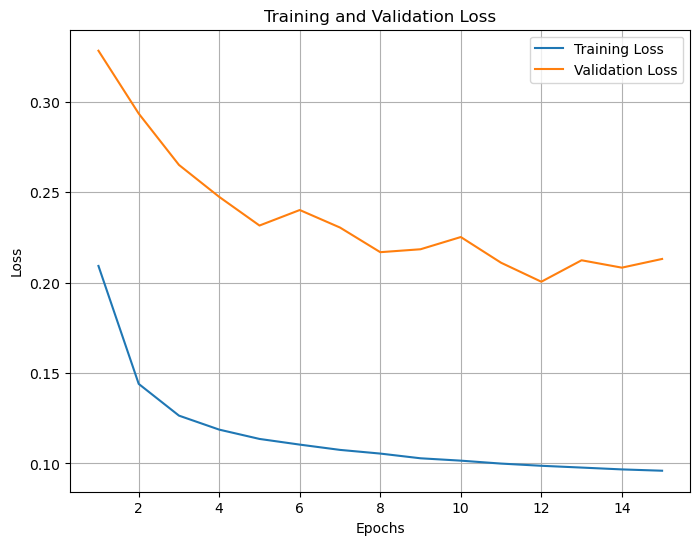

In [8]:
import matplotlib.pyplot as plt


training_loss = history.history['loss']
validation_loss = history.history['val_loss']


epochs = range(1, len(training_loss) + 1)


plt.figure(figsize=(8, 6))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
model.save_weights('influenza_capstone_model.h5')

In [10]:
test_data = pd.read_csv('/kaggle/input/capstone-sequences/victoria_seq_to_seq (1).csv')
test_encoder_inputs_data = []
test_decoder_inputs_data = []
test_target_outputs_data = []
for i in range(len(test_data)):
    base = test_data.loc[i]['base']
    mutated = test_data.loc[i]['mutated']
    test_encoder_inputs_data.append([tokens.index(nucleotide) if nucleotide in tokens else randint(3,6) for nucleotide in base])
    test_decoder_inputs_data.append([tokens.index('<START>')] + [tokens.index(nucleotide) if nucleotide in tokens else randint(3,6) for nucleotide in mutated])
    test_target_outputs_data.append([int(tokens.index(nucleotide)) if nucleotide in tokens else randint(3,6) for nucleotide in mutated] + [int(tokens.index('<END>'))])

test_encoder_inputs_data = pad_sequences(test_encoder_inputs_data, padding='post',maxlen=max_length)
test_decoder_inputs_data = pad_sequences(test_decoder_inputs_data, padding='post',maxlen=max_length)
test_target_outputs_data = pad_sequences(test_target_outputs_data, padding='post',maxlen=max_length)

In [12]:
len(test_data)

48947

In [11]:
model.evaluate(x=[test_encoder_inputs_data,test_decoder_inputs_data],y=test_target_outputs_data)

1530/1530 [==============================] - 99s 65ms/step - loss: 0.2761 - masked_accuracy: 0.9251


[0.27613648772239685, 0.9250525832176208]

In [60]:
import numpy as np
from Bio import pairwise2

scores = []

for sample in range(10):
    if sample%100 == 0:
        try:
            print(sum(scores)/len(scores))
        except:
            pass
    decoded_seq = pad_sequences([[tokens.index('<START>')]], padding='post',maxlen=max_length)
    pred = model.predict([test_encoder_inputs_data[sample:sample+1],decoded_seq],verbose=0,batch_size=2)
    a = [tokens[np.argmax(i)] for i in pred[0]]
    generated = ''.join(a)
    actual = generated.split('<END>')[0]
    
    
    b = [tokens[i] for i in test_decoder_inputs_data[sample:sample+1][0] if i not in [0,1,2]]
    b = ''.join(b)

    alignments = pairwise2.align.globalxx(actual.upper(), b.upper())
    best_alignment = alignments[0]

    scores.append(best_alignment.score/len(b))

In [61]:
sum(scores)/len(scores)

0.8849534032343549

In [57]:
sample = 23
decoded_seq = pad_sequences([[tokens.index('<START>')]], padding='post',maxlen=max_length)
pred = model.predict([test_encoder_inputs_data[sample:sample+1],decoded_seq],verbose=0,batch_size=2)
a = [tokens[np.argmax(i)] for i in pred[0]]
generated = ''.join(a)
actual = generated.split('<END>')[0]


b = [tokens[i] for i in test_decoder_inputs_data[sample:sample+1][0] if i not in [0,1,2]]
b = ''.join(b)

alignments = pairwise2.align.globalxx(actual.upper(), b.upper())
best_alignment = alignments[0]

#print(pairwise2.format_alignment(*best_alignment))
print(best_alignment.seqB)
print('Length of ground truth: ',len(b),'\n \n','Length normalized alignment score: ',best_alignment.score/len(b))


ATGGATACTTTTATTACAAGAAACTTCCAGACTACAATAATACAAAAGGCCAAAAACACAATGGCAGAATTTAGTGAAGATCCTGAACTACAACCAGCAATGCTATTCAACATCTGCGTCCATCTAGAGGTTTGCTATGTAATAAGTGACATGAATTTTCTTGACGAAGAAGGAAAAGCATATACAGCATTAGAAGGACAAGGGAAAGAACAAAACCTGAGACCACAATATGAAGTA-ATTGAGGGAATGCCAAGAACCATAGCATGGATGGTCCAAAGATCCTTAGCTCAAGAGCATGGAATAGAGACTCCAAAGTATCTGGCTGATTTGTTTGATTATAAAACCAAGAGATTTATAGAAGTTGGAATAACAAAAGGATTGGCTGATGATTACTTTTGGAAAAAGAAAGAAAAGCTGGGAAATAGCATGGAACTGATGATATTCAGCTACAATCAAGACTATTCGTTAAGTAATGAATCCTCACTG-GATGAGGAAGGGAAAGGGA-GAGTGCTAAGCAGACTCACAGAACTTCAGGCTGA-ATTAAGTCTGAAAAACCTATGGCAAGTTCTCATAGGGGAAGAAGATGTTGAAAAGGGAATT-AACTTT-AAACTTGGACAAACAATATCTAGACTAAGGGATATATCTGTTCCAGCTGGTTTCTCCAATTTTGAAGGAATGAGG-AGCTACATAGACAATATAG-ATCCTAAAGGAGCAATAGAGAGAAA-TCTAGCAAGGATGTCTCC-CTTAGTATC-AGCCACACCTAAAAAGTTG-AAATGGGAGGACCTAAGACCTATAGG-GCCTCACATTTACA-ACCATG-AGCTACCAGAAGTTCCATATAATGCCTTTCTTCTAATGTCTGATGAATTGGGGCTGGCCAATATGACTGAGGGAAGGTCCAAAAAACCGAAGACATTAGCCAAAGAATGTCTAGAAAAGTA-CTCAACACTACGGGATCAAACTGACCCAATATTAATAATGAAAAGC

1/1 [==============================] - 0s 186ms/step


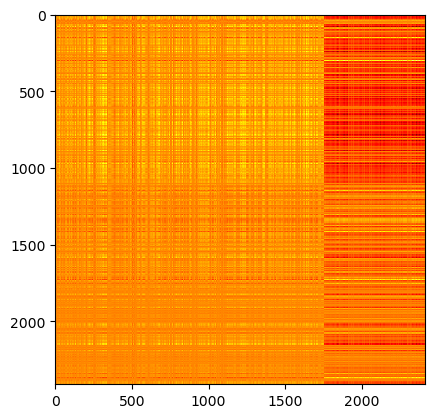

In [53]:
import matplotlib.pyplot as plt
encoder_attention = keras.Model(inputs=model.input,outputs=model.get_layer('encoder_1').output)
sample = 0
encoder_pred = encoder_attention.predict([encoder_inputs_data[sample:sample+1],decoder_inputs_data[sample:sample+1]])
plt.imshow(encoder_pred[1][0][0], cmap='hot', interpolation='nearest')